# Tâche 9

### Ce notebook permet de calculer les températures de Debye et d'Einstein pour le NaInS2 telles que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique. 
### Après cela, on représente les courbes de la chaleur spécifique(celle du NaInS2 et celles obtenues avec les modèles d'Eistein et de Debye) et les densités d'états de phonons correspondantes


In [7]:
import numpy as np  
from mp_api.client import MPRester  
import matplotlib.pyplot as plt  
from scipy import integrate  
from pymatgen.io.cif import CifWriter 
from IPython.display import FileLink, display  

key = "kHK7l7itQo2c5bLbQQIsHOTh5cQ7HUnw"  
material = "mp-20289"  

m = MPRester(key)  
prime_struct = m.get_structure_by_material_id(material)  

w = CifWriter(prime_struct)  
w.write_file(material + ".cif") 

print("Voici un lien pour télécharger la structure")  
display(FileLink(material + ".cif"))

ph_dos = m.get_phonon_dos_by_material_id(material)



Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Voici un lien pour télécharger la structure


/home/users/r/p/rperger/mp-20289.cif

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# Courbe de la chaleur spécifique

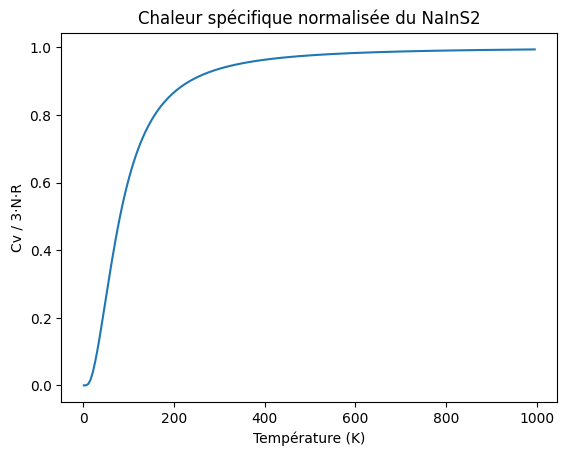

In [8]:
# On crée une liste de températures allant de 1 K à 1000 K par pas de 5 K
# On commence à 1 K pour éviter une division par zéro dans les formules

temps = np.arange(1, 1000, 5)  
R = 8.314  # Constante des gaz parfaits en J/(mol·K)

# On compte le nombre total d'atomes dans la cellule cristalline du matériau
nb_atomes = len(prime_struct)

# On calcule la chaleur spécifique réelle à partir de la densité d’états phononique
# ph_dos.cv(T) donne Cv total pour T donné, on le normalise par 3·N·R pour le comparer aux modèles
liste_cv = [ph_dos.cv(t) / (3 * nb_atomes * R) for t in temps]

# On trace la courbe de Cv réel normalisé en fonction de la température
plt.plot(temps, liste_cv)
plt.title("Chaleur spécifique normalisée du NaInS2") 
plt.xlabel("Température (K)")  
plt.ylabel("Cv / 3·N·R")  
plt.show()

# Modèle d'Eistein

Température d'Einstein optimale : 242 K


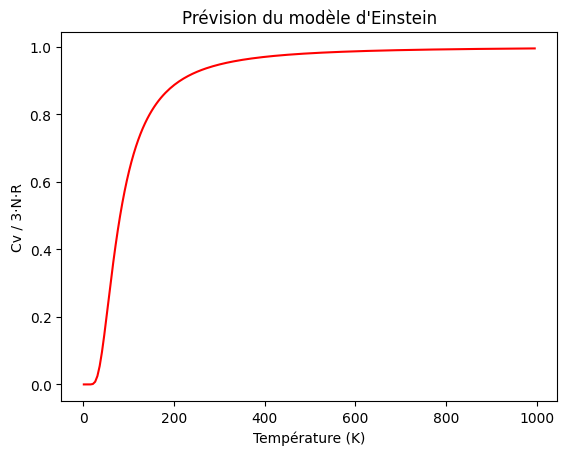

In [9]:
# Le modèle d’Einstein suppose que tous les atomes vibrent à la même fréquence (oscillateurs identiques)
# Cela permet de prédire comment la chaleur spécifique évolue avec la température

def modele_einstein(theta_e, T):
    if T == 0:
        return 0
    y = theta_e / T
    if y > 700:  # On évite les erreurs de dépassement numérique (overflow)
        return 0
    try:
        exp_y = np.exp(y)
        denom = exp_y - 1
        if denom == 0:
            return 0
        return (y**2 * exp_y) / (denom**2)  # Formule normalisée de Cv selon Einstein
    except OverflowError:
        return 0

# On cherche la température d’Einstein θ_E qui donne la meilleure correspondance avec les données réelles
meilleure_erreur_e = float('inf')
theta_e_opt = None

for theta_test in range(1, 1000):  # On teste différentes valeurs possibles de θ_E
    cumul_diff = 0
    for idx in range(1, 200):  # On calcule l’erreur quadratique entre le modèle et les données réelles
        diff = modele_einstein(theta_test, temps[idx]) - liste_cv[idx]
        cumul_diff += diff**2
    if cumul_diff < meilleure_erreur_e:
        meilleure_erreur_e = cumul_diff
        theta_e_opt = theta_test

print("Température d'Einstein optimale :", theta_e_opt, "K")

# On calcule les prédictions du modèle d’Einstein avec la meilleure température trouvée
cv_theorique_e = [modele_einstein(theta_e_opt, T) for T in temps]

# On trace la courbe prédite par le modèle d’Einstein
plt.plot(temps, cv_theorique_e, color='red')
plt.title("Prévision du modèle d'Einstein")
plt.xlabel("Température (K)")
plt.ylabel("Cv / 3·N·R")
plt.show()


### Le modèle d’Einstein suppose que tous les atomes vibrent à la même fréquence et chaque atome est considéré comme un oscillateur harmonique identique. 
### Ce modèle permet d’estimer la chaleur spécifique à différentes températures mais à basse température, il sous-estime le comportement réel car il ignore la diversité des modes vibratoires (pas de phonons acoustiques).
### La température caractéristique est la température d'Einstein θ<sub>E</sub>.

# Modèle de Debye

Température de Debye optimale : 327 K


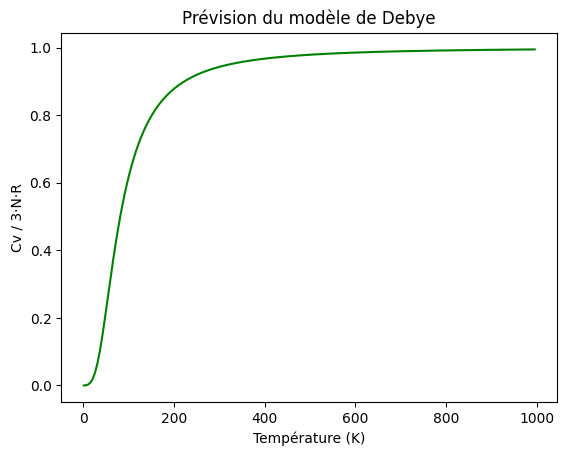

In [10]:
# Le modèle de Debye est plus réaliste : il suppose que les atomes vibrent avec un spectre de fréquences
# Il intègre les vibrations acoustiques (basses fréquences) jusqu'à une fréquence maximale (fréquence de Debye)

# Fonction intégrée dans le modèle de Debye
def integrande(x):
    try:
        exp_x = np.exp(x)
        denom = (exp_x - 1)
        if denom == 0:
            return 0
        return (x**4 * exp_x) / (denom**2)
    except OverflowError:
        return 0

# Formule de la chaleur spécifique normalisée dans le modèle de Debye
def modele_debye(theta_d, T):
    if T == 0:
        return 0
    x = theta_d / T
    if x > 700:
        x = 700
    try:
        val, _ = integrate.quad(integrande, 0, x, limit=100)
        return 3 * (T / theta_d)**3 * val
    except:
        return 0

# On cherche la température de Debye θ_D qui donne le meilleur ajustement avec les données réelles
meilleure_erreur_d = float('inf')
theta_d_opt = None

for test_d in range(1, 1000):
    ecart_total = 0
    for idx in range(1, 200):
        prediction = modele_debye(test_d, temps[idx])
        ecart_total += (prediction - liste_cv[idx])**2
    if ecart_total < meilleure_erreur_d:
        meilleure_erreur_d = ecart_total
        theta_d_opt = test_d

print("Température de Debye optimale :", theta_d_opt, "K")

# On calcule les prédictions du modèle de Debye avec la température optimale trouvée
cv_theorique_d = [modele_debye(theta_d_opt, T) for T in temps]

# On trace la courbe de chaleur spécifique prédite par le modèle de Debye
plt.plot(temps, cv_theorique_d, color="green")
plt.title("Prévision du modèle de Debye")
plt.xlabel("Température (K)")
plt.ylabel("Cv / 3·N·R")
plt.show()

### Le modèle de Debye est plus réaliste : il suppose que les atomes vibrent selon un spectre continu de fréquences jusqu’à une fréquence maximale appelée fréquence de Debye.Il tient compte des modes acoustiques (basses fréquences), ce qui lui permet de mieux décrire le comportement à basse température.

### La température caractéristique est la température de Debye θ<sub>D</sub>.

# comparaison des diffèrentes courbes

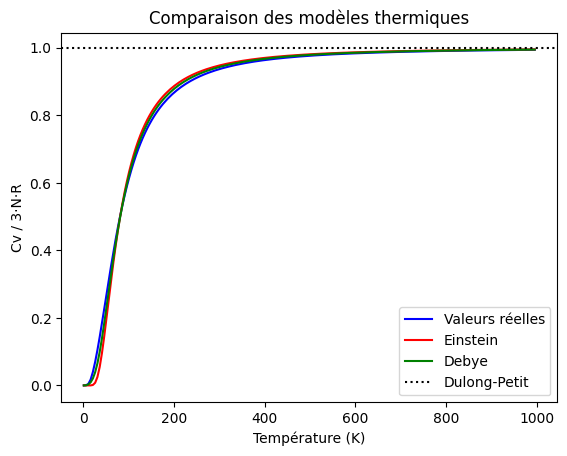

In [11]:
# On compare visuellement les courbes de Cv normalisé :
# - Les données réelles (obtenues via Materials Project)
# - Le modèle d’Einstein
# - Le modèle de Debye

plt.plot(temps, liste_cv, label="Valeurs réelles", color='blue')
plt.plot(temps, cv_theorique_e, label="Einstein", color='red')
plt.plot(temps, cv_theorique_d, label="Debye", color='green')
plt.axhline(y=1, linestyle='dotted', color='black', label="Dulong-Petit")
plt.title("Comparaison des modèles thermiques")
plt.xlabel("Température (K)")
plt.ylabel("Cv / 3·N·R")
plt.legend()
plt.show()

# Méthode de calcul des températures optimales


### Pour chaque modèle (Einstein et Debye), on recherche la température caractéristique (θ<sub>E</sub> ou θ<sub>D</sub>) qui minimise l’erreur  entre la chaleur spécifique prédite par le modèle et les données réelles.

### On teste sur des températures qui vont de 1K à 1000K on choisit celle qui donne la meilleure correspondance.

# comparaison des densités d'états de phonons

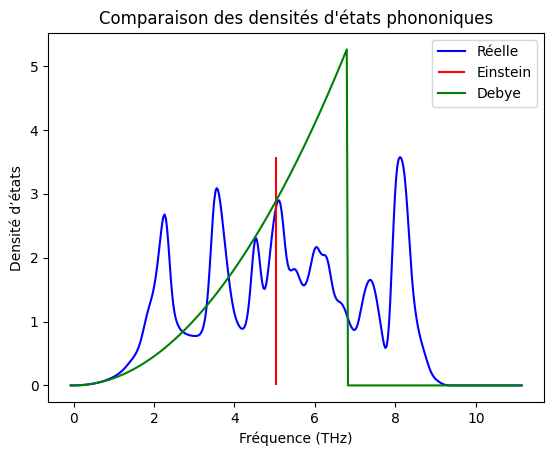

In [12]:
# On passe maintenant à la représentation des densités d'états phononiques :
# Cela montre comment les différentes fréquences de vibration sont réparties dans le matériau

# Constantes physiques
k_B = 1.380649e-23  # Constante de Boltzmann en J/K
h_barre = 1.055e-34  # Constante de Planck réduite en J·s

# Extraction des données réelles
frequences = ph_dos.frequencies  # fréquences en THz
densite_reelle = ph_dos.densities  # densité d'états réelle

# Températures caractéristiques
omega_e = k_B * theta_e_opt / h_barre  # rad/s
f_einstein = omega_e / (2 * np.pi * 1e12)  # fréquence en THz

omega_d = k_B * theta_d_opt / h_barre  # rad/s

# Densité d'états du modèle de Debye 
densite_debye = []
f_d = omega_d / (2 * np.pi * 1e12)  # conversion de ω_D en fréquence THz

for f in frequences:
    if f < f_d:
        val = (9 * nb_atomes * f**2) / (f_d**3)  # en THz
    else:
        val = 0
    densite_debye.append(val)

# Tracé des courbes
plt.plot(frequences, densite_reelle, label="Réelle", color="blue")
plt.vlines(f_einstein, 0, max(densite_reelle), color="red", label="Einstein")  # pic vertical à f_E
plt.plot(frequences, densite_debye, label="Debye", color="green")

plt.title("Comparaison des densités d'états phononiques")
plt.xlabel("Fréquence (THz)")
plt.ylabel("Densité d’états")
plt.legend()
plt.show()

#### Le modèle d’Einstein suppose que tous les atomes vibrent à la même fréquence et donc la densité d’états est donc un pic unique centré sur cette fréquence
#### Le modèle de Debye considère une distribution continue des fréquences jusqu’à une fréquence maximale  ω<sub>D</sub>, liée à la température de Debye. La densité d’états suit une loi définie par :

$$
g(\omega) \propto 
\begin{cases}
\omega^2 & \text{si } \omega \leq \omega_D \\
0 & \text{si } \omega > \omega_D
\end{cases}
$$

où $ \omega = 2\pi \nu $ avec $ \nu $ la fréquence en Hz.
#### Les données réelles permettent d’avoir une courbe avec plusieurs pics, représentant les différentes vibrations (acoustiques et optiques) dans le cristal.
